## Transfer Learning
Various tricks that you can try to fit your data on the existing pretrained model. 

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-04-27 12:31:25--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.87.60, 54.192.87.92, 54.192.87.67, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.87.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  19.5MB/s    in 2.3s    

2020-04-27 12:31:27 (19.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [0]:
# For reproducible results. 
def torch_seeding(seed):
    if torch.cuda.is_available():
      # for CUDA
      if torch.cuda.device_count() > 1:
        torch.cuda.manual_seed_all(seed)
      else:
        torch.cuda.manual_seed(seed)
      if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic=True

      return torch.device("cuda:0")

    else:
      # for CPU
      torch.manual_seed(seed)

      return torch.device("cpu")

device = torch_seeding(1122)

## Data Preprocessor and Generator.

In [4]:
# Mean and Standard devation coming from image-net dataset

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['ants', 'bees']


## Display Images

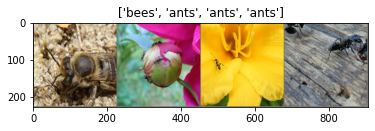

torch.Size([4, 3, 224, 224])


In [5]:

def imshow(inp, title):
    """
    imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print(inputs.size())


## Deep Neural Network Training. 

In [0]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                if scheduler:
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## Finetunning The Network.

In [14]:
# Load a pretrained model and reset final fully connected layer.
Adam = 1

model = models.resnet152(pretrained=True)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
if Adam:
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model = train_model(model, criterion, optimizer, None, num_epochs=25)
else:  
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
    # Decay LR by a factor of 0.1 every 7 epochs
    # Learning rate scheduling should be applied after optimizer’s update
    # e.g., you should write your code this way:
    # for epoch in range(100):
    #     train(...)
    #     validate(...)
    #     scheduler.step()

    step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5869 Acc: 0.7500
val Loss: 0.3920 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3985 Acc: 0.8525
val Loss: 0.2344 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3244 Acc: 0.8730
val Loss: 0.1859 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3234 Acc: 0.8607
val Loss: 0.1810 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3183 Acc: 0.8689
val Loss: 0.1575 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.2430 Acc: 0.9016
val Loss: 0.1460 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2039 Acc: 0.9303
val Loss: 0.1305 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.2281 Acc: 0.9180
val Loss: 0.1688 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2832 Acc: 0.8689
val Loss: 0.1279 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2218 Acc: 0.9139
val Loss: 0.1666 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2304 Acc: 0.9016
val Loss: 0.1597 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2929 Acc: 0.8893
val Loss: 0.1552 Acc: 0.9412

Ep

## Training Final Layer. 

In [15]:

#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6112 Acc: 0.6803
val Loss: 0.5430 Acc: 0.6993

Epoch 1/24
----------
train Loss: 0.4141 Acc: 0.7992
val Loss: 0.1564 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3752 Acc: 0.8361
val Loss: 0.1331 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4372 Acc: 0.8074
val Loss: 0.1607 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3918 Acc: 0.8320
val Loss: 0.2029 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3817 Acc: 0.8402
val Loss: 0.3227 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5377 Acc: 0.7910
val Loss: 0.1189 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3105 Acc: 0.8607
val Loss: 0.1199 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4184 Acc: 0.8320
val Loss: 0.1208 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2988 Acc: 0.8689
val Loss: 0.1198 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2919 Acc: 0.8975
val Loss: 0.1465 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2583 Acc: 0.8730
val Loss: 0.1195 Acc: 0.9608

Ep

## Play With Model.

In [16]:
# Train final layer i.e. Full Conneccted layer alone. 

model = torchvision.models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


Epoch 0/19
----------
train Loss: 0.5483 Acc: 0.6885
val Loss: 0.1813 Acc: 0.9477

Epoch 1/19
----------
train Loss: 0.4595 Acc: 0.7787
val Loss: 0.2759 Acc: 0.8889

Epoch 2/19
----------
train Loss: 0.5032 Acc: 0.7869
val Loss: 0.1615 Acc: 0.9085

Epoch 3/19
----------
train Loss: 0.3806 Acc: 0.8443
val Loss: 0.1144 Acc: 0.9608

Epoch 4/19
----------
train Loss: 0.4173 Acc: 0.8279
val Loss: 0.1190 Acc: 0.9542

Epoch 5/19
----------
train Loss: 0.4580 Acc: 0.8279
val Loss: 0.1316 Acc: 0.9477

Epoch 6/19
----------
train Loss: 0.3228 Acc: 0.8566
val Loss: 0.2321 Acc: 0.9020

Epoch 7/19
----------
train Loss: 0.3347 Acc: 0.8525
val Loss: 0.1054 Acc: 0.9542

Epoch 8/19
----------
train Loss: 0.2326 Acc: 0.8975
val Loss: 0.1157 Acc: 0.9608

Epoch 9/19
----------
train Loss: 0.2801 Acc: 0.8730
val Loss: 0.1110 Acc: 0.9477

Epoch 10/19
----------
train Loss: 0.2430 Acc: 0.8975
val Loss: 0.0990 Acc: 0.9608

Epoch 11/19
----------
train Loss: 0.2726 Acc: 0.8852
val Loss: 0.0993 Acc: 0.9673

Ep

In [17]:
# Now, unfreeze the complete model. 
# Change and lr and make it reduce based on gamma and step_size id reduced. 

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)


Epoch 0/5
----------
train Loss: 0.3248 Acc: 0.8607
val Loss: 0.1002 Acc: 0.9739

Epoch 1/5
----------
train Loss: 0.3219 Acc: 0.8566
val Loss: 0.1018 Acc: 0.9608

Epoch 2/5
----------
train Loss: 0.2875 Acc: 0.8730
val Loss: 0.1131 Acc: 0.9542

Epoch 3/5
----------
train Loss: 0.2938 Acc: 0.8689
val Loss: 0.1102 Acc: 0.9542

Epoch 4/5
----------
train Loss: 0.2447 Acc: 0.9016
val Loss: 0.1182 Acc: 0.9477

Epoch 5/5
----------
train Loss: 0.2678 Acc: 0.8566
val Loss: 0.1173 Acc: 0.9412

Training complete in 1m 18s
Best val Acc: 0.973856
